In [20]:
import os
import sys
from pathlib import Path
sys.path.append(os.path.dirname(os.path.abspath(Path.cwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import src.data_prep.split_data as sd
# import src.data_prep.preprocess as pp
# import src.data_prep.eda as eda
# from src.data_prep.suppress_output import suppress_stdout_stderr
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import classification_report, accuracy_score, make_scorer
# from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix


## Load the Dataset

We will load the basic stats dataset from user 1 that we create in the analysis.ipynb notebook, and split the dataset into the train set and the test set:

In [21]:
# load the dataset to a pandas df
data = pd.read_csv("../data/train_data/basic_stats/subject_1.csv")
data.head()

,min_x,max_x,mean_x,std_x,range_x,min_y,max_y,mean_y,std_y,range_y,min_z,max_z,mean_z,std_z,range_z,activity
0,1940,1986,1961.088462,7.673593,46,2365,2396,2377.584615,5.437301,31,2086,2143,2115.726923,11.339209,57,1
1,1925,1999,1956.119231,12.374358,74,2340,2409,2379.503846,9.438890,69,2062,2168,2106.846154,18.925973,106,1
2,1919,1999,1953.280769,12.488837,80,2340,2409,2380.869231,9.430001,69,2062,2168,2101.476923,17.485666,106,1
3,1919,1977,1959.707692,10.208972,58,2368,2394,2379.800000,5.014881,26,2077,2138,2107.876923,10.598328,61,1
4,1941,1980,1964.134615,5.983339,39,2369,2390,2378.407692,3.633172,21,2086,2135,2113.100000,6.042130,49,1


In [22]:
X = data.loc[:, data.columns != 'activity']
y = data['activity']

# split the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

## Set up a BaseLine model

We will be using a Linear Classifier as our baseline model.

In [23]:
# Initialize the regresstion
reg = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
#scale the data first
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# fit the model
reg.fit(X_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
# Print out the report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        74
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        22
           4       0.97      0.97      0.97        62
           5       0.86      1.00      0.92         6
           6       0.60      0.60      0.60         5
           7       0.89      1.00      0.94       194

    accuracy                           0.92       365
   macro avg       0.62      0.65      0.63       365
weighted avg       0.86      0.92      0.89       365



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


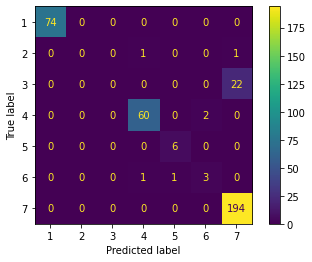

In [24]:
# plot confusion matrix
plot_confusion_matrix(reg, X_test_scaled, y_test) 
plt.show()

The Logistic Regression Classifier was able to predict accurately 92% of the sequence's labels. We will try out several more classifiers and hopefully we'll get a better result than the baseline model.